# Empirically Investigating the Relationship Between Bayesian Priors and Regularization Penalty Terms

Introductions to Bayesian methods often remark that regularizing linear regression with an L2 penalty is equivalent to having a Gaussian prior over the distribution of coefficient terms in a linear model. In this notebook, I would like to explore this empirically, by comparing the cross-validated performance of both a MLE and a Bayesian formulation of linear regression. I will verify that an L2 penalty term corresponds to a Gaussian prior, that an L1 penalty corresponds to a Laplacean prior, and will examine the relationship between the tuning parameter values of the penalties and the dispersions of the prior distributions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt

from scipy.stats import skew

from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from priors_penalties_functions import BayesianGLM
from priors_penalties_functions import plot_errors_and_coef_magnitudes, cross_validate_hyperparam_choices

import os
print(os.listdir("../input"))

['house-prices-advanced-regression-techniques']


## Import/Preprocess Data

In [2]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Preprocessing

I will follow the methodology in https://www.kaggle.com/apapiu/regularized-linear-models. That is, taking the log of skewed features, creating dummy variables for categorical features, and performing mean imputation.

After these steps, I will choose just 5 features to work with in order to reduce the feature space to something that is feasible to sample with MCMC. Note that because of this step, predictions made by models will not do very well on the leaderboard (they are relatively simple models to begin with, being variants of simple linear regression). That is okay, because the purpose of this notebook is to explore an equivalence between two formulations of linear regression.

In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# Create dummy variables
all_data = pd.get_dummies(all_data)

# Mean imputation
all_data = all_data.fillna(all_data.mean())

In [5]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [6]:
selector = SelectKBest(f_regression, k=5)
selector.fit(X_train, y)

scaler = StandardScaler()
scaler.fit(X_train, y)

columns = X_train.columns[selector.get_support()]

X_train = pd.DataFrame(selector.transform(scaler.transform(X_train)), columns=columns)
X_test = pd.DataFrame(selector.transform(scaler.transform(X_test)), columns=columns)

X_train.head()

,OverallQual,1stFlrSF,GrLivArea,GarageCars,GarageArea
0,0.651479,-0.803645,0.529194,0.311725,0.351000
1,-0.071836,0.418479,-0.381965,0.311725,-0.060731
2,0.651479,-0.576677,0.659631,0.311725,0.631726
3,0.651479,-0.439421,0.541448,1.650307,0.790804
4,1.374795,0.112127,1.282295,1.650307,1.698485


## L2 Penalty (Ridge Regression)

In [7]:
cv_splitter = KFold(5)

In [8]:
alphas = np.logspace(0, 6, num=20)
alphas

array([1.00000000e+00, 2.06913808e+00, 4.28133240e+00, 8.85866790e+00,
       1.83298071e+01, 3.79269019e+01, 7.84759970e+01, 1.62377674e+02,
       3.35981829e+02, 6.95192796e+02, 1.43844989e+03, 2.97635144e+03,
       6.15848211e+03, 1.27427499e+04, 2.63665090e+04, 5.45559478e+04,
       1.12883789e+05, 2.33572147e+05, 4.83293024e+05, 1.00000000e+06])

In [9]:
results_l2 = cross_validate_hyperparam_choices(alphas, X_train, y, cv_splitter, Ridge)
results_l2

,alpha,mean_error,mean_largest_coef_value,log_alpha
0,1.000000,0.178267,0.184681,0.000000
1,2.069138,0.178257,0.184464,0.315789
2,4.281332,0.178239,0.184019,0.631579
3,8.858668,0.178205,0.183106,0.947368
4,18.329807,0.178155,0.181260,1.263158
5,37.926902,0.178122,0.177609,1.578947
6,78.475997,0.178281,0.170712,1.894737
7,162.377674,0.179230,0.158711,2.210526
8,335.981829,0.182522,0.140359,2.526316
9,695.192796,0.191392,0.116495,2.842105


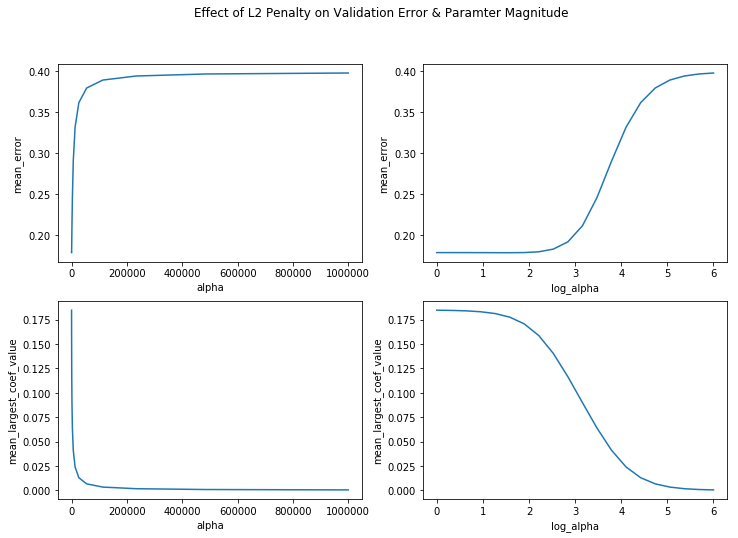

In [10]:
plot_errors_and_coef_magnitudes(results_l2, "Effect of L2 Penalty on Validation Error & Paramter Magnitude");

### Bayesian GLM

In the probabilistic formulation of linear regression, the response variable, $Y$, is treated as a random variable, equal to the weighted sum of the features, $\beta X$, plus random noise. The noise is typically assumed to be Gaussian, hence the distribution of $Y$ is also Gaussian.

That is, $Y \sim \mathcal{N}(\beta X, \sigma^2)$, where $\sigma^2$ is the variance of the noise term you would find in the standard formulation of linear regression, $Y = \beta X + \epsilon, \epsilon \sim \mathcal{N}$, $(0 \sigma^2)$.

Furthermore, we can specify prior distributions over the parameters $\beta$. A common choice is the Gaussian distribution. If we center this distribution around 0, this would indicate that we expect the parameters to be small. Choosing small values for the standard deviation of this prior would correspond to a tighter distribution, indicating a stronger initial belief in small parameters - similar to a large penalty in regularized least-squares regression.

PyMC3 has a module dedicated to Bayesian GLMs (https://docs.pymc.io/api/glm.html). However, for some reason they will not sample in the Kaggle kernel environment. I suspect it has to do with some Theano backend operation, as my first attempt to make a function from scratch that involved dot products had similar behavior. In any case, I have made my own GLM class due to the problems the library function has in this programming environment. I've modeled it after the scikit-learn API so that I can use it in my cross-validation loop.

In [11]:
sigmas = np.sqrt(1 / alphas)
sigmas

array([1.        , 0.6951928 , 0.48329302, 0.33598183, 0.23357215,
       0.16237767, 0.11288379, 0.078476  , 0.05455595, 0.0379269 ,
       0.02636651, 0.01832981, 0.01274275, 0.00885867, 0.00615848,
       0.00428133, 0.00297635, 0.00206914, 0.00143845, 0.001     ])

In [12]:
results_normal = cross_validate_hyperparam_choices(sigmas, X_train, y, cv_splitter, BayesianGLM, 
                                                   is_bayesian=True, bayesian_prior_fn=pm.Normal)
results_normal

,mean_error,mean_largest_coef_value,sigma,log_sigma
0,0.178510,0.184708,1.000000,0.000000
1,0.178557,0.184543,0.695193,-0.157895
2,0.178446,0.183334,0.483293,-0.315789
3,0.178438,0.183073,0.335982,-0.473684
4,0.178335,0.181068,0.233572,-0.631579
5,0.178332,0.177650,0.162378,-0.789474
6,0.178480,0.170989,0.112884,-0.947368
7,0.179489,0.158452,0.078476,-1.105263
8,0.182820,0.140619,0.054556,-1.263158
9,0.191696,0.116379,0.037927,-1.421053


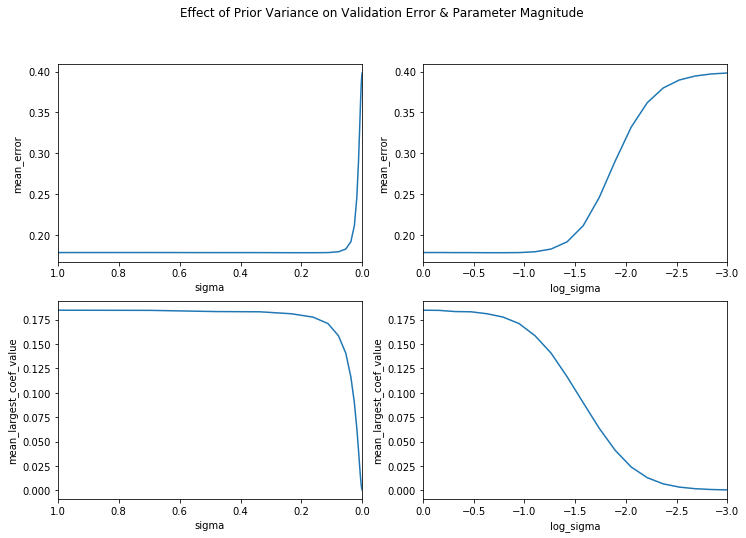

In [13]:
plot_errors_and_coef_magnitudes(results_normal, 
                                "Effect of Prior Variance on Validation Error & Parameter Magnitude",
                                hyperparam_name="sigma",
                                reverse_x=True);

## L1 Penalty (Lasso)

In [14]:
results_l1 = cross_validate_hyperparam_choices(alphas, X_train, y, cv_splitter, Lasso)
results_l1

,alpha,mean_error,mean_largest_coef_value,log_alpha
0,1.000000,0.399226,0.0,0.000000
1,2.069138,0.399226,0.0,0.315789
2,4.281332,0.399226,0.0,0.631579
3,8.858668,0.399226,0.0,0.947368
4,18.329807,0.399226,0.0,1.263158
5,37.926902,0.399226,0.0,1.578947
6,78.475997,0.399226,0.0,1.894737
7,162.377674,0.399226,0.0,2.210526
8,335.981829,0.399226,0.0,2.526316
9,695.192796,0.399226,0.0,2.842105


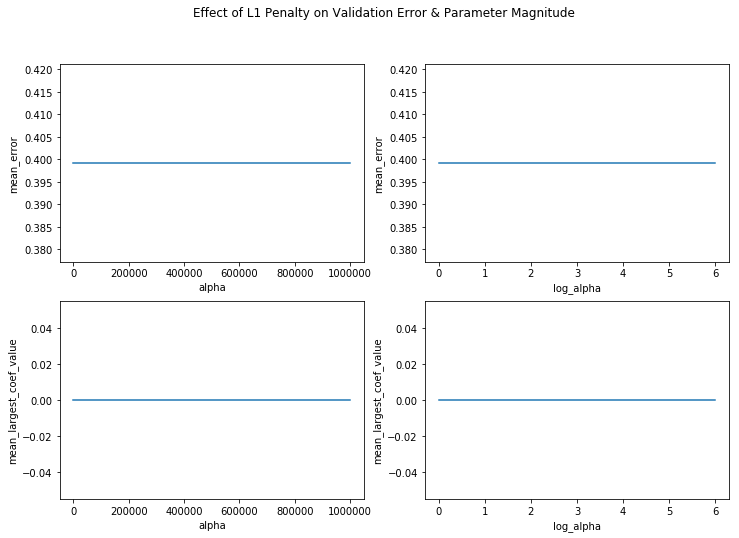

In [15]:
plot_errors_and_coef_magnitudes(results_l1, "Effect of L1 Penalty on Validation Error & Parameter Magnitude");

## Laplace Prior

In [16]:
results_laplace = cross_validate_hyperparam_choices(sigmas, X_train, y, cv_splitter, BayesianGLM, 
                                                   is_bayesian=True, bayesian_prior_fn=pm.Laplace)
results_laplace

,mean_error,mean_largest_coef_value,sigma,log_sigma
0,0.178501,0.183607,1.000000,0.000000
1,0.178442,0.183787,0.695193,-0.157895
2,0.178401,0.183483,0.483293,-0.315789
3,0.178363,0.183586,0.335982,-0.473684
4,0.178376,0.182751,0.233572,-0.631579
5,0.178382,0.181395,0.162378,-0.789474
6,0.178343,0.180417,0.112884,-0.947368
7,0.178507,0.179055,0.078476,-1.105263
8,0.178907,0.176726,0.054556,-1.263158
9,0.179945,0.172889,0.037927,-1.421053


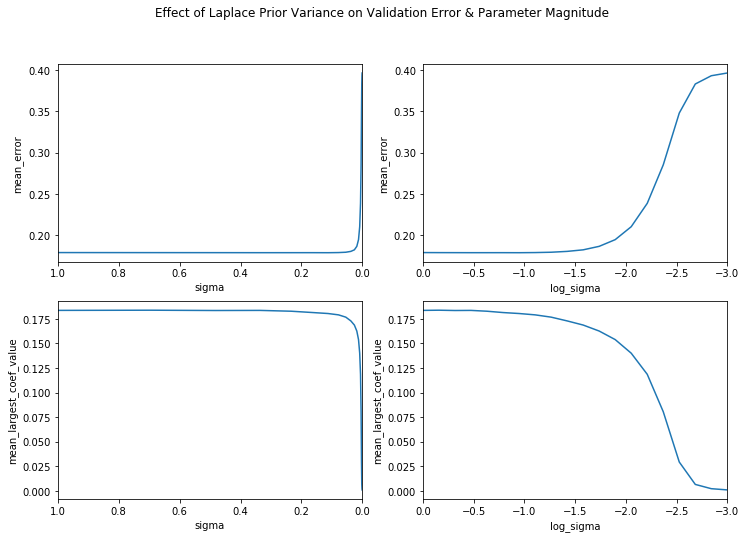

In [17]:
plot_errors_and_coef_magnitudes(results_laplace, 
                                "Effect of Laplace Prior Variance on Validation Error & Parameter Magnitude",
                                hyperparam_name="sigma",
                                reverse_x=True);